<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Binary Variational Semantic Hashing </h1>

<H3 align='center'> Extensión trabajo CIARP </H3>
<hr style="height:2px;border:none"/>

In [7]:
import numpy as np
import keras,gc, os, time, sys
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from scipy.special import expit

from base_networks import *
from utils import check_availability, load_imgs_mask

from utils import get_topK_labels,set_newlabel_list, enmask_data

np.random.seed(20)

In [2]:
!ls Data/VGG_128

celeba_VGG_avg.npy   cifar10_VGG.npy	mnist_VGG.npy	     nuswide_VGG.npy
cifar10_VGG_avg.npy  mnist_VGG_avg.npy	nuswide_VGG_avg.npy


## Load Data

### MNIST
---

Imágenes en blanco y negro de 28x28 píxeles, de números del 0 al 9, que dan orígen a las 10 clases del problema.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|60000|10|
|Pruebas|10000|10|

In [33]:
name_dat = "MNIST"

(_, aux_t), (_, aux_test) = keras.datasets.mnist.load_data()
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

#X_t = np.load("./Data/VGG_CNN/mnist_VGG_avg.npy")
#X_t = np.load("./Data/VGG_64/mnist_VGG_avg.npy")
X_t = np.load("./Data/VGG_128/mnist_VGG_avg.npy")

X_t.shape

(70000, 512)

In [34]:
##### 1000 imagenes de prueba... 
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=False)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  69000
Cantidad de datos Pruebas:  1000


### CIFAR-10
---
Imágenes RGB pequeñas de  32x32 píxeles, de fotos naturales de distintos objetos.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|50000|10|
|Pruebas|10000|10|

In [35]:
name_dat = "CIFAR-10"

(_, aux_t), (_, aux_test) = keras.datasets.cifar10.load_data()

labels = ["airplane", "automobile","bird", "cat","deer","dog","frog","horse","ship","truck"]
labels_t = np.asarray([labels[value[0]] for value in aux_t])
labels_test = np.asarray([labels[value[0]] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

#X_t = np.load("./Data/VGG_CNN/cifar10_VGG_avg.npy")
#X_t = np.load("./Data/VGG_64/cifar10_VGG_avg.npy") #mejora

X_t = np.load("./Data/VGG_128/cifar10_VGG_avg.npy") #mejora
#X_t = np.load("./Data/VGG_224/cifar10_VGG_avg.npy") #mejora

X_t.shape

(60000, 512)

In [36]:
##### 1000 imagenes de prueba... 
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=False)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  59000
Cantidad de datos Pruebas:  1000


### NUSWIDE
---
* Cantidad de datos totales: 269648
* Datos utlizados (con imagenes disponibles a descargar): 169500
* Datos top-21 clases: 158383

Imágenes de eventos con 81 tópicos asociados, re-dimensionadas a 64x64.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|81|
|Validación|xxx|81|
|Pruebas|xxx|81|

In [62]:
name_dat = "Nus-Wide"

folder = "../Dataset_NUSWIDE/"
folder_imgs_name = folder+"small_images/"

mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

labels = pd.read_csv(folder+'Concepts81.txt',header=None).values.reshape(1,-1)[0]
print("Cantidad de labels: ",len(labels) )

labels_t = [[] for _ in range(269648)]
for concept in labels:
    aux = pd.read_csv(folder+"Groundtruth/AllLabels/Labels_"+concept+".txt",header=None)
    indexs_true = aux.loc[(aux==1).values[:,0]].index
    
    for value in indexs_true:
        labels_t[value].append(concept)
        
labels_t = enmask_data(labels_t, mask_av)
N_total = len(labels_t)
print("Cantidad de objetos: ",N_total )

labels_t[:5]

Cantidad de labels:  81
Cantidad de objetos:  169500


[['person'], ['person'], ['person'], ['person'], ['person']]

#### get top-K labels data

In [63]:
new_labels = get_topK_labels(labels_t, labels, K=21)

labels_t = set_newlabel_list(new_labels, labels_t)
labels = new_labels
# y si quedan datos sin clase?
mask_used_t = np.asarray(list(map(len,labels_t))) != 0

labels_t = enmask_data(labels_t, mask_used_t)
print("Cantidad de objetos: ", len(labels_t) )

category with most data (sky) has = 61066, the top-K category (mountain) has = 4232
Cantidad de objetos:  158383


N_used = 80*1000 #o 150k??
idx_all = np.arange(0, N_total)
mask_used = np.zeros(N_total, dtype=bool)
mask_used[np.random.choice(np.arange(0, N_total), size=N_used, replace=False)] = 1
mask_used

In [64]:
#X_t = np.load("./Data/VGG_CNN/nuswide_VGG.npy")
#X_t = np.load("./Data/VGG_CNN/nuswide_VGG_avg.npy")
X_t = np.load("./Data/VGG_128/nuswide_VGG_avg.npy")
X_t.shape

(158383, 512)

In [65]:
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  156283
Cantidad de datos Pruebas:  2100


### CelebA
---
* Cantidad de datos totales: 202599
* Datos en plataforma Kaggle:https://www.kaggle.com/jessicali9530/celeba-dataset 

Imágenes RGB re-dimensionadas a 64x64 píxeles, de fotos naturales de rostros de celebridades. Una muestra es utilizada

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|40|
|Validación|xxx|40|
|Pruebas|xxx|40|

mask_av = check_availability(folder+"small_images/", labels_t)
np.savetxt("./Data/+"name_dat+"_mask_avail.txt", mask_av, fmt="%1i")

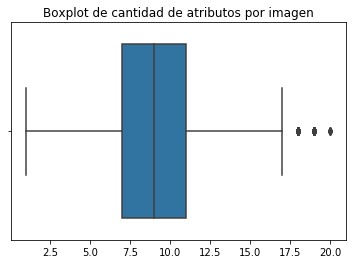

In [3]:
sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de topics por imagen")
plt.show()

In [92]:
name_dat = "CelebA"
mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

folder = "../CelebA/"

part = pd.read_csv(folder+"list_eval_partition.csv")
mask_train = (part["partition"].values == 0)[mask_av]
mask_val = (part["partition"].values == 1)[mask_av]
mask_test = (part["partition"].values == 2)[mask_av]

df_atrr = pd.read_csv(folder+"list_attr_celeba.csv")[mask_av]
img_names = df_atrr["image_id"].values
labels = list(df_atrr.columns[1:])
print("Cantidad de labels: ",len(labels) )

N_total = len(df_atrr)
print("Cantidad de objetos: ",N_total )
aux = (df_atrr == 1).values
labels_t = np.asarray([list(df_atrr.columns[aux[value]]) for value in range(N_total)])
labels[:5]

Cantidad de labels:  40
Cantidad de objetos:  202599


['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald']

In [93]:
X_t = np.load("./Data/VGG_128/celeba_VGG_avg.npy")
X_t.shape

(202599, 512)

In [94]:
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  198599
Cantidad de datos Pruebas:  4000


### Validation creation

Pre-process: División por 255

In [35]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_t)

X_t = std.transform(X_t)
X_test = std.transform(X_test)
X_t

array([[-0.01111989, -0.11184615, -0.1498022 , ..., -0.31169224,
         0.69140774, -0.5642056 ],
       [-0.01111989, -0.11184615, -0.1498022 , ..., -0.31169224,
        -1.256413  , -0.5642056 ],
       [-0.01111989, -0.11184615, -0.1498022 , ..., -0.31169224,
         0.19021511,  0.39075068],
       ...,
       [-0.01111989, -0.11184615,  0.50946474, ..., -0.31169224,
        -0.3174135 ,  1.3644001 ],
       [-0.01111989, -0.11184615, -0.1498022 , ..., -0.31169224,
        -0.4524642 , -0.5642056 ],
       [-0.01111989, -0.11184615, -0.1498022 , ..., -0.31169224,
         2.0684183 ,  0.22856563]], dtype=float32)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, labels_train, labels_val  = train_test_split(X_t, labels_t, random_state=20,test_size=len(X_test))

print("Cantidad de datos Entrenamiento: ",len(X_train))
print("Cantidad de datos Validación: ",len(X_val))
print("Cantidad de datos Pruebas: ",len(X_test))
del X_t, labels_t
gc.collect()

Cantidad de datos Entrenamiento:  68000
Cantidad de datos Validación:  1000
Cantidad de datos Pruebas:  1000


10

### Model Architecture
---
CNN
https://github.com/rtflynn/Cifar-Autoencoder

In [14]:
def REC_loss(x_true, x_pred):
    return K.mean( (x_true- x_pred)**2 ,axis=-1) 

In [15]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True, beta_ann=False):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN, out_type='linear')
    print("generator network:")
    generator.summary()
    
    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)
    
    if beta_ann:
        beta = K.variable(0., name="kl_weight")
    else:
        beta = 1./10 #value is not tested
    
    Recon_loss = REC_loss
    kl_loss = KL_loss(z_mean,z_log_var)
    def VAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt, loss=VAE_loss, metrics = [Recon_loss,kl_loss])
    
    if beta_ann:
        return traditional_vae, encoder,generator ,beta
    else:
        return traditional_vae, encoder,generator

#traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae,encoder_Tvae,generator_Tvae,beta_T = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta_ann=True)
traditional_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

In [16]:
import keras.backend as K
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)

def binary_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True,beta_ann=False):
    tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3
    
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN, out_type='linear')
    print("generator network:")
    generator.summary()

    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    #dist = Dense(Nb, activation='sigmoid')(hidden) #p(b) #otra forma de modelarlo
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)

    if beta_ann:
        beta = K.variable(0., name="kl_weight")
    else:
        beta = 1./100 #value not tested..
        
    Recon_loss = REC_loss
    kl_loss = BKL_loss(logits_b)
    def BVAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=BVAE_loss, metrics = [Recon_loss,kl_loss])
    if beta_ann:
        return binary_vae, encoder,generator ,beta
    else:
        return binary_vae, encoder,generator
    
#binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae,encoder_Bvae,generator_Bvae, beta_B= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta_ann=True)
binary_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

### Train details
---

* 30* epochs* 
* *batch size* de 200
* optimizador Adam
* Inicializador de Glorot (para los pesos)

In [17]:
from utils import  compare_hist_train, add_hist_plot

batch_size = 100*2 #ya que son datasets mas grandes
epochs = 30 

In [102]:
hist1 = traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val) #) 
                        ,callbacks=[Beta_Call(beta_T,kl_inc=(1./50000),max_KL=0.01, verbose=1)] )

Train on 194599 samples, validate on 4000 samples
Epoch 1/30
194599/194599 [==============================] - 3s - loss: 0.7046 - REC_loss: 0.7046 - KL: 187.3230 - val_loss: 0.6189 - val_REC_loss: 0.6189 - val_KL: 268.1130
Epoch 2/30
194599/194599 [==============================] - 2s - loss: 0.6261 - REC_loss: 0.6221 - KL: 199.7685 - val_loss: 0.6130 - val_REC_loss: 0.6094 - val_KL: 181.9387
Epoch 3/30
194599/194599 [==============================] - 2s - loss: 0.6260 - REC_loss: 0.6178 - KL: 136.3596 - val_loss: 0.6144 - val_REC_loss: 0.6069 - val_KL: 126.1433
Epoch 4/30
194599/194599 [==============================] - 2s - loss: 0.6288 - REC_loss: 0.6167 - KL: 100.7695 - val_loss: 0.6180 - val_REC_loss: 0.6062 - val_KL: 97.9266
Epoch 5/30
194599/194599 [==============================] - 2s - loss: 0.6336 - REC_loss: 0.6171 - KL: 82.4103 - val_loss: 0.6235 - val_REC_loss: 0.6072 - val_KL: 81.4676
Epoch 6/30
194599/194599 [==============================] - 2s - loss: 0.6394 - REC_loss

In [103]:
hist2 = binary_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val) #)
                        ,callbacks=[Beta_Call(beta_B,kl_inc=(1./50000),max_KL=0.01, verbose=1)] )

Train on 194599 samples, validate on 4000 samples
Epoch 1/30
194599/194599 [==============================] - 2s - loss: 0.8063 - REC_loss: 0.8063 - KL: 16.8315 - val_loss: 0.7512 - val_REC_loss: 0.7512 - val_KL: 18.0863
Epoch 2/30
194599/194599 [==============================] - 2s - loss: 0.7551 - REC_loss: 0.7547 - KL: 17.9975 - val_loss: 0.7401 - val_REC_loss: 0.7397 - val_KL: 18.1589
Epoch 3/30
194599/194599 [==============================] - 2s - loss: 0.7493 - REC_loss: 0.7482 - KL: 18.1252 - val_loss: 0.7372 - val_REC_loss: 0.7361 - val_KL: 18.1804
Epoch 4/30
194599/194599 [==============================] - 2s - loss: 0.7473 - REC_loss: 0.7451 - KL: 18.1605 - val_loss: 0.7357 - val_REC_loss: 0.7336 - val_KL: 18.1863
Epoch 5/30
194599/194599 [==============================] - 2s - loss: 0.7468 - REC_loss: 0.7431 - KL: 18.1663 - val_loss: 0.7358 - val_REC_loss: 0.7321 - val_KL: 18.1626
Epoch 6/30
194599/194599 [==============================] - 2s - loss: 0.7468 - REC_loss: 0.741

In [65]:
hist2 = binary_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val) )

Train on 58000 samples, validate on 1000 samples
Epoch 1/30
58000/58000 [==============================] - 1s - loss: 1.0473 - REC_loss: 1.0165 - KL: 3.0786 - val_loss: 0.9716 - val_REC_loss: 0.9163 - val_KL: 5.5361
Epoch 2/30
58000/58000 [==============================] - 0s - loss: 0.9047 - REC_loss: 0.8476 - KL: 5.7121 - val_loss: 0.8983 - val_REC_loss: 0.8211 - val_KL: 7.7175
Epoch 3/30
58000/58000 [==============================] - 0s - loss: 0.8592 - REC_loss: 0.7836 - KL: 7.5525 - val_loss: 0.8636 - val_REC_loss: 0.7739 - val_KL: 8.9738
Epoch 4/30
58000/58000 [==============================] - 0s - loss: 0.8360 - REC_loss: 0.7499 - KL: 8.6068 - val_loss: 0.8487 - val_REC_loss: 0.7531 - val_KL: 9.5645
Epoch 5/30
58000/58000 [==============================] - 0s - loss: 0.8232 - REC_loss: 0.7295 - KL: 9.3681 - val_loss: 0.8369 - val_REC_loss: 0.7340 - val_KL: 10.2847
Epoch 6/30
58000/58000 [==============================] - 0s - loss: 0.8156 - REC_loss: 0.7171 - KL: 9.8462 - val_l

MAP on CIFAR-10 dataset
Binary VAE =  0.26078252060154106
Binary VAE con precision y recall para B-VAE 0.29790560000000016 0.25684758476811426
CIFAR-10


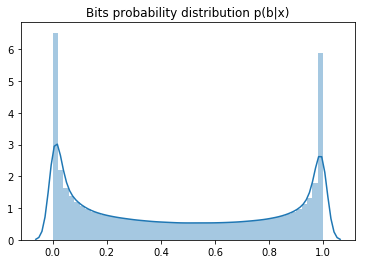

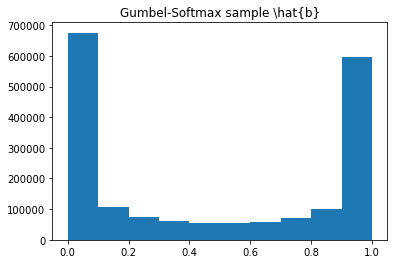

In [66]:
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_train,X_test)

print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_train,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

p_b,r_b = evaluate_hashing_DE(total_hash_BVAE,test_hash_BVAE,labels_train,labels_test,eval_tipo="PRatk",K=5000)
print("Binary VAE con precision y recall para B-VAE",p_b,r_b)

X_train_logits = encoder_Bvae.predict(X_train)
X_train_Bcode = expit(X_train_logits)
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

In [55]:
binary_vae,encoder_Bvae,generator_Bvae, beta_B= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta_ann=True)

hist2 = binary_vae.fit(X_train, X_train, epochs=40, batch_size=batch_size
                           ,validation_data=(X_val,X_val) #)
                        ,callbacks=[Beta_Call(beta_B,kl_inc=1*(1./5000)/10,max_KL=1*(0.1)/10, verbose=1)] )

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_29 (Batc (None, 500)               2000      
_________________________________________________________________
dense_44 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_30 (Batc (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

MAP on CIFAR-10 dataset
Binary VAE =  0.26695753400649314
Binary VAE con precision y recall para B-VAE 0.30544999999999967 0.2633436109193072
CIFAR-10


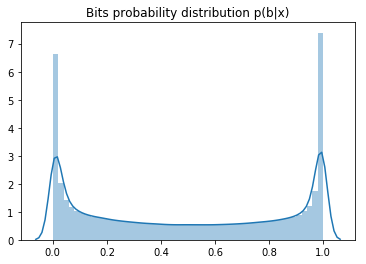

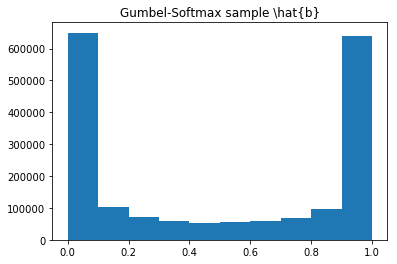

In [56]:
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_train,X_test)

print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_train,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

p_b,r_b = evaluate_hashing_DE(total_hash_BVAE,test_hash_BVAE,labels_train,labels_test,eval_tipo="PRatk",K=5000)
print("Binary VAE con precision y recall para B-VAE",p_b,r_b)

X_train_logits = encoder_Bvae.predict(X_train)
X_train_Bcode = expit(X_train_logits)
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

In [57]:
binary_vae,encoder_Bvae,generator_Bvae, beta_B= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta_ann=True)

hist2 = binary_vae.fit(X_train, X_train, epochs=50, batch_size=batch_size
                           ,validation_data=(X_val,X_val) #)
                        ,callbacks=[Beta_Call(beta_B,kl_inc=2*(1./5000)/10,max_KL=2*(0.1)/10, verbose=1)] )

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_31 (Batc (None, 500)               2000      
_________________________________________________________________
dense_47 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_32 (Batc (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

In [58]:
total_hash_VAE, test_hash_VAE = hash_data(encoder_Tvae,X_train,X_test, binary=False)
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_train,X_test)

print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_train,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_train,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)


p_t,r_t = evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_train,labels_test,eval_tipo="PRatk",K=5000)
print("Traditional VAE con precision y recall para VAE",p_t,r_t)

p_b,r_b = evaluate_hashing(total_hash_BVAE,test_hash_BVAE,labels_train,labels_test,eval_tipo="PRatk",K=5000)
print("Binary VAE con precision y recall para B-VAE",p_b,r_b)

MAP on CIFAR-10 dataset
Traditional VAE =  0.1300238920315121
Binary VAE =  0.23215855195559734


NameError: name 'evaluate_hashing' is not defined

In [ ]:
X_train_logits = encoder_Bvae.predict(X_train)
X_train_Bcode = expit(X_train_logits)
X_train_Tcode = encoder_Tvae.predict(X_train)

print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_mean(X_train_Tcode)

In [59]:
binary_vae,encoder_Bvae,generator_Bvae, beta_B= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta_ann=True)

hist2 = binary_vae.fit(X_train, X_train, epochs=50, batch_size=batch_size
                           ,validation_data=(X_val,X_val) #)
                        ,callbacks=[Beta_Call(beta_B,kl_inc=3*(1./5000)/10,max_KL=3*(0.1)/10, verbose=1)] )

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_33 (Batc (None, 500)               2000      
_________________________________________________________________
dense_50 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_34 (Batc (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

MAP on CIFAR-10 dataset
Binary VAE =  0.19117537461894313
Binary VAE con precision y recall para B-VAE 0.22423019999999996 0.19331749174259377
CIFAR-10


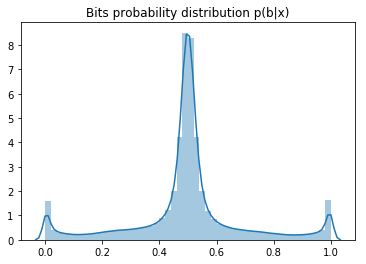

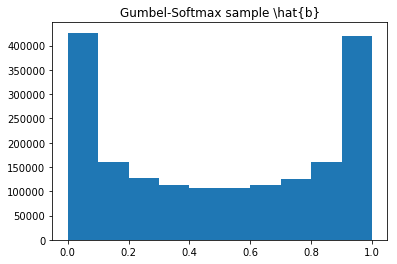

In [60]:
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_train,X_test)

print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_train,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

p_b,r_b = evaluate_hashing_DE(total_hash_BVAE,test_hash_BVAE,labels_train,labels_test,eval_tipo="PRatk",K=5000)
print("Binary VAE con precision y recall para B-VAE",p_b,r_b)

X_train_logits = encoder_Bvae.predict(X_train)
X_train_Bcode = expit(X_train_logits)
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode) ##

In [61]:
binary_vae,encoder_Bvae,generator_Bvae, beta_B= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta_ann=True)

hist2 = binary_vae.fit(X_train, X_train, epochs=50, batch_size=batch_size
                           ,validation_data=(X_val,X_val) #)
                        ,callbacks=[Beta_Call(beta_B,kl_inc=5*(1./5000)/10,max_KL=5*(0.1)/10, verbose=1)] )

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_35 (Batc (None, 500)               2000      
_________________________________________________________________
dense_53 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_36 (Batc (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

MAP on CIFAR-10 dataset
Binary VAE =  0.16982325497060946
Binary VAE con precision y recall para B-VAE 0.20372339999999994 0.17563077594402104
CIFAR-10


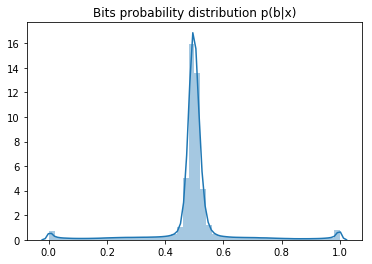

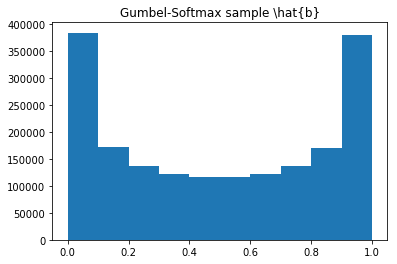

In [62]:
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_train,X_test)

print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_train,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

p_b,r_b = evaluate_hashing_DE(total_hash_BVAE,test_hash_BVAE,labels_train,labels_test,eval_tipo="PRatk",K=5000)
print("Binary VAE con precision y recall para B-VAE",p_b,r_b)

X_train_logits = encoder_Bvae.predict(X_train)
X_train_Bcode = expit(X_train_logits)
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode) ##

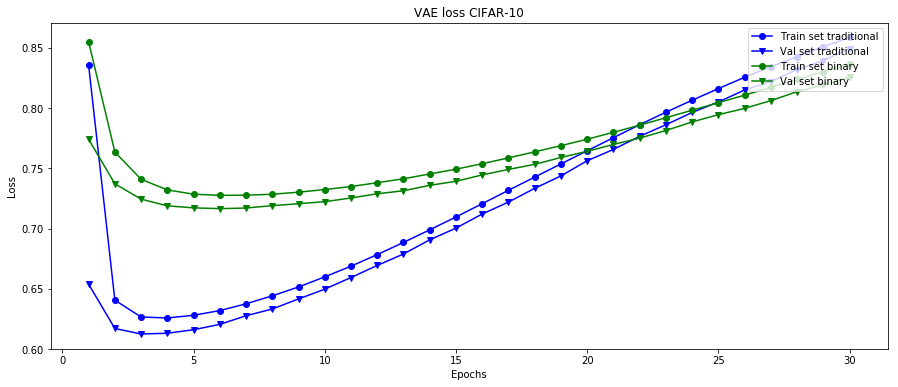

In [13]:
compare_hist_train(hist1,hist2, name_dat)

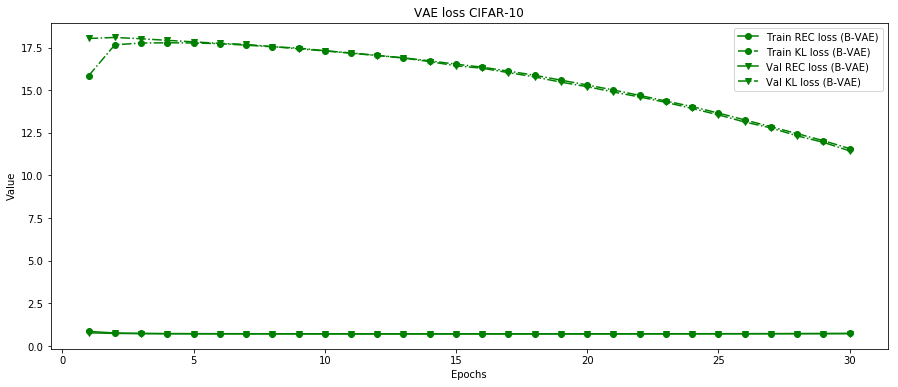

In [16]:
plt.figure(figsize=(15,6))
add_hist_plot(hist2, c='g', model_n = "B-VAE")
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE loss "+name_dat)
plt.show()

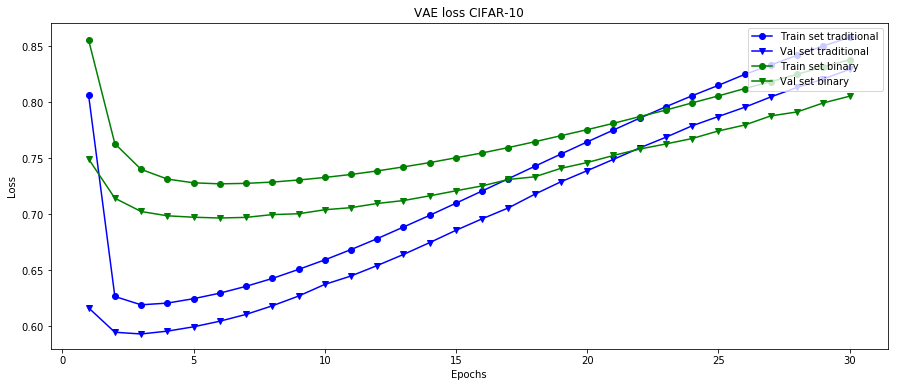

In [43]:
compare_hist_train(hist1,hist2, name_dat)

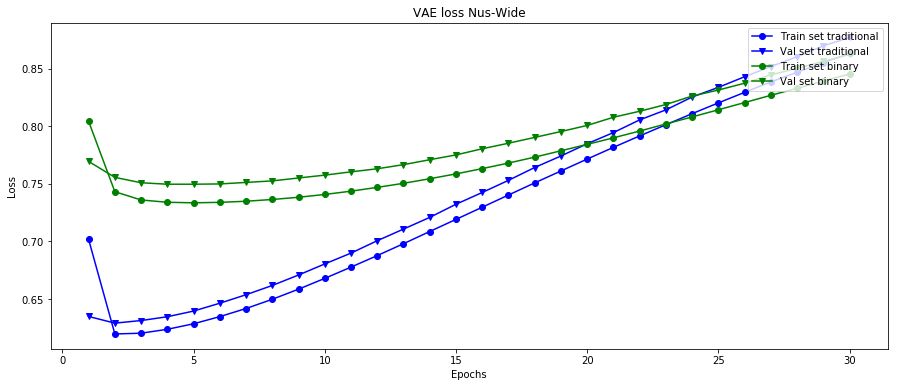

In [72]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

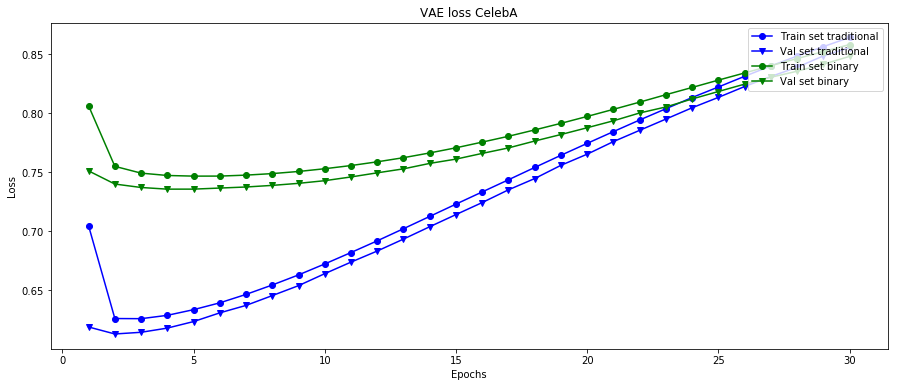

In [104]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

### Another intrinsic measure: *Classification*


In [13]:
#function to define and train model
from sklearn.metrics import jaccard_score
from utils import define_fit, MedianHashing, visualize_probas, visualize_mean, calculate_hash

results = []
results_S = []
results_B = []
results_O_B = [] #original testing on tresholded

In [105]:
#codify input data (binarize -- or aprox)
X_train_logits = encoder_Bvae.predict(X_train)
X_val_logits = encoder_Bvae.predict(X_test)

#probabilities
X_train_Bcode = expit(X_train_logits)
X_val_Bcode = expit(X_val_logits)

#Z-mean
X_train_Tcode = encoder_Tvae.predict(X_train)
X_val_Tcode = encoder_Tvae.predict(X_test)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    inputs = np.asarray(inputs)
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list or type(aux_labels) == np.ndarray :
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_train)
#C_val = codify_labels(labels_val)
C_val = codify_labels(labels_test)
C_train

array([[1., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.]])

MNIST


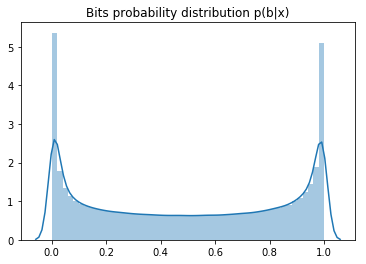

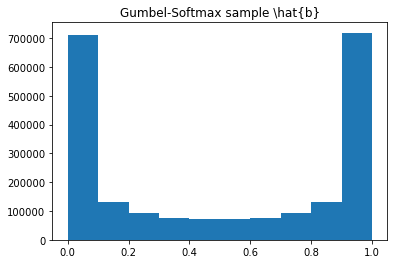

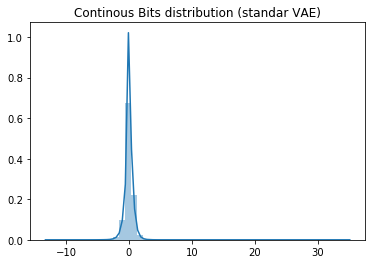

In [15]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_mean(X_train_Tcode)

CIFAR-10


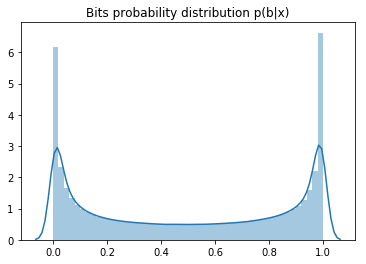

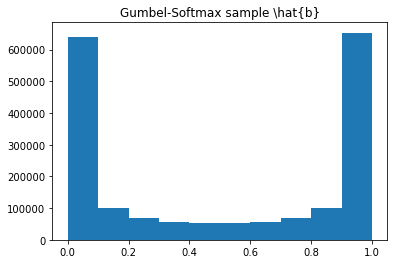

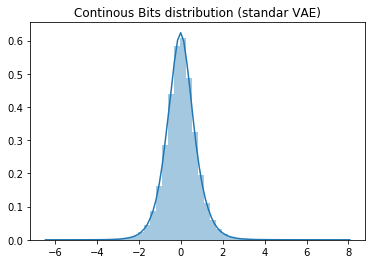

In [45]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_mean(X_train_Tcode)

Nus-Wide


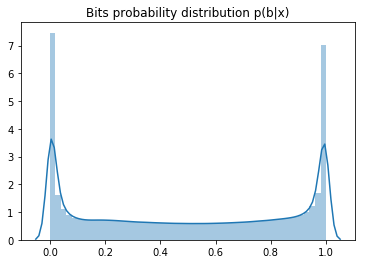

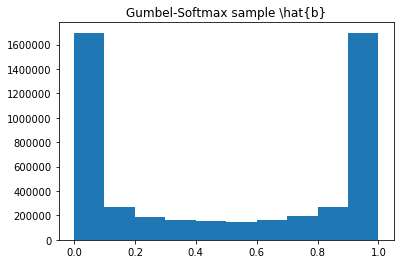

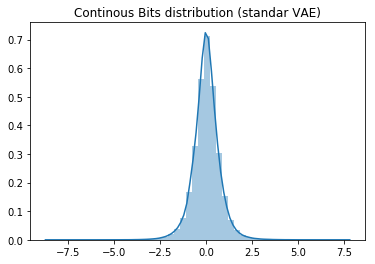

In [74]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_mean(X_train_Tcode)

CelebA


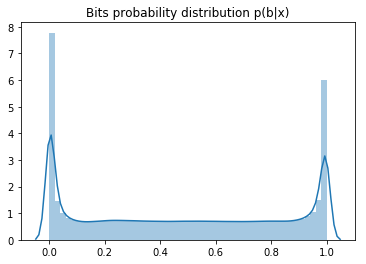

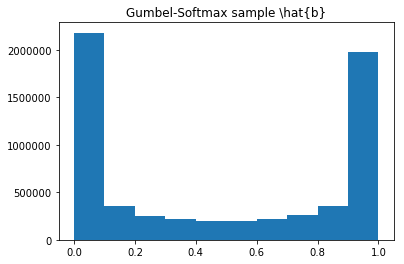

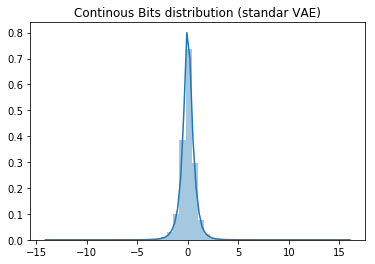

In [106]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_mean(X_train_Tcode)

In [107]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1_O = define_fit(multi_label,X_train_Bcode,C_train)
model2_O = define_fit(multi_label,X_train_Tcode,C_train)

if not multi_label:
    aux.append(model2_O.evaluate(X_train_Tcode,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

Done


In [108]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))


Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.966882 - 0.956000
Binary VAE (train-val): 0.954941 - 0.943000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.871724 - 0.843000
Binary VAE (train-val): 0.824190 - 0.815000

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.505285 - 0.447885
Binary VAE (train-val): 0.493766 - 0.445415

Accuracy on dataset:  celeba
Traditional VAE (train-val): 0.452790 - 0.424564
Binary VAE (train-val): 0.436319 - 0.407941


In [109]:
## binary // treshold it

X_train_Tcode_B = calculate_hash(X_train_Tcode, from_probas=False)
X_val_Tcode_B = calculate_hash(X_val_Tcode, from_probas=False)

X_train_Bcode_B = calculate_hash(X_train_Bcode, from_probas=True, from_logits=False)
X_val_Bcode_B = calculate_hash(X_val_Bcode, from_probas=True, from_logits=False)

X_train_Tcode_B

array([[0, 1, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 0, 1]], dtype=int32)

In [110]:
### trained models over encoder representation testing on tresholded representation (see how decrease)
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

if not multi_label:
    aux.append(model2_O.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_O_B.append(aux)
print("Done")

Done


In [111]:
print("Classification on Binary (thresholded) representation")
for valores in results_O_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary (thresholded) representation

Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.288765 - 0.272000
Binary VAE (train-val): 0.891941 - 0.886000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.448000 - 0.419000
Binary VAE (train-val): 0.723845 - 0.709000

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.314612 - 0.263097
Binary VAE (train-val): 0.402046 - 0.365614

Accuracy on dataset:  celeba
Traditional VAE (train-val): 0.352294 - 0.345801
Binary VAE (train-val): 0.406070 - 0.389705


In [112]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)
model2 = define_fit(multi_label,X_train_Tcode_B,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode_B)>=0.5)*1, average='micro')) 
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

Done


In [113]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.896515 - 0.878000
Binary VAE (train-val): 0.920147 - 0.908000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.745224 - 0.708000
Binary VAE (train-val): 0.756259 - 0.721000

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.424745 - 0.366612
Binary VAE (train-val): 0.431372 - 0.376573

Accuracy on dataset:  celeba
Traditional VAE (train-val): 0.408293 - 0.373377
Binary VAE (train-val): 0.407063 - 0.373759




### Results
---

In [18]:
from utils import MedianHashing, get_similar, measure_metrics, calculate_hash
from utils import MAP_atk, M_P_atk, AP_atk

### Experimentación
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [24]:
def evaluate_hashingB(encoder,train,val,labels_train,labels_val,traditional=True,tipo="topK",K=100):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    
    train_hash = calculate_hash(encode_train, from_probas=~traditional )
    val_hash = calculate_hash(encode_val, from_probas=~traditional)

    val_similares_train =  get_similar(val_hash, train_hash, tipo=tipo,K=K) 

    return measure_metrics(labels,val_similares_train,labels_query=labels_val,labels_source=labels_train)


### Experimentando variando el #Bits

In [29]:
traditional_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]}}
binary_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]}}

In [33]:
Nbits = np.asarray([4,8,16,32,64])
dataset = name_dat.lower()

for Nbit in Nbits:
    traditional_vae, encoder_Tvae, generator_Tvae,beta_U = traditional_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0, beta_ann=True)
    traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,verbose=0, 
                        callbacks=[Beta_Call(beta_U, verbose=0)])
    
    p_t,r_t = evaluate_hashingB(encoder_Tvae,X_train,X_val,labels_train,labels_val,traditional=True,tipo="topK")
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    del traditional_vae, encoder_Tvae, generator_Tvae
    keras.backend.clear_session()
    gc.collect()
    
    binary_vae, encoder_Bvae, generator_Bvae,beta_U = binary_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0, beta_ann=True)
    binary_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,verbose=0,
                   callbacks=[Beta_Call(beta_U, verbose=0)] )
    p_b,r_b = evaluate_hashingB(encoder_Bvae,X_train,X_val,labels_train,labels_val,traditional=False,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
    del binary_vae, encoder_Bvae, generator_Bvae
    keras.backend.clear_session()
    gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_11 (Batc (None, 500)               2000      
_________________________________________________________________
dense_25 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_12 (Batc (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

KeyboardInterrupt: 

In [ ]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["p"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["p"]
#t["Nus-Wide"] = traditional_dat["nus-wide"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["p"]
t["CIFAR-10"] = binary_dat["cifar-10"]["p"]
#t["Nus-Wide"] = binary_dat["nus-wide"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["r"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["r"]
#t["Nus-Wide"] = traditional_dat["nus-wide"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["r"]
t["CIFAR-10"] = binary_dat["cifar-10"]["r"]
#t["Nus-Wide"] = binary_dat["nus-wide"]["r"]
print("\n*** VAE Binary***")
print(t)

## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil *tokens* más frecuentes y *Term Frequency*

In [19]:
from utils import calculate_hash
def evaluate_hashing_DE(train_hash,test_hash,labels_trainn,labels_testt,tipo="topK",eval_tipo='PRatk',K=100):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    test_similares_train =  get_similar(test_hash,train_hash,tipo=tipo,K=K)
    if eval_tipo=="MAP":
        return MAP_atk(test_similares_train,labels_query=labels_testt, labels_source=labels_trainn, K=0) #all ranking
    elif eval_tipo == "PRatk":
        return measure_metrics(labels,test_similares_train,labels_testt,labels_source=labels_trainn)
    elif eval_tipo == "Patk":
        return M_P_atk(test_similares_train, labels_query=labels_testt, labels_source=labels_trainn, K=K)

def hash_data(model, x_train, x_test, binary=True):
    encode_train = model.predict(x_train)
    encode_test = model.predict(x_test)
    
    train_hash = calculate_hash(encode_train, from_probas=binary )
    test_hash = calculate_hash(encode_test, from_probas = binary)
    return train_hash, test_hash

#to save results
results_dat = {"mnist":{"p":[],"r":[],'p5k':[]},
               "cifar-10":{"p":[],"r":[], 'p5k':[]},
               "celeba":{"p":[],"r":[],'p5k':[]},
              "nus-wide":{"p":[],"r":[],'p5k':[]}} 

BITS_S = 32

In [37]:
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)
del X_train, X_val, labels_train,labels_val
gc.collect()

0

In [30]:
traditional_vae, encoder_Tvae, generator_Tvae,beta_T = traditional_VAE(X_total.shape[1],Nb=BITS_S,units=500,layers_e=2,layers_d=0,beta_ann=True)
traditional_vae.fit(X_total, X_total, epochs=50, batch_size=batch_size,verbose=1, 
                        callbacks=[Beta_Call(beta_T, kl_inc = (1./50000), max_KL=0.01, verbose=1)])
#save model
#encoder_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
###generator_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_D_defaultCNN.h5") #it is not used


binary_vae, encoder_Bvae, generator_Bvae,beta_B = binary_VAE(X_total.shape[1],Nb=BITS_S,units=500,layers_e=2,layers_d=0,beta_ann=True )
binary_vae.fit(X_total, X_total, epochs=50, batch_size=batch_size,verbose=1,
                   callbacks=[Beta_Call(beta_B, kl_inc = (1./50000), max_KL=0.01, verbose=1)] )
#save model
#encoder_Bvae.save("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
#generator_Bvae.save_weights("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN_w.h5")

#keras.backend.clear_session()
#gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               392500    
_________________________________________________________________
batch_normalization_9 (Batch (None, 500)               2000      
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_10 (Batc (None, 500)               2000      
Total params: 647,000
Trainable params: 645,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

In [38]:
traditional_vae, encoder_Tvae, generator_Tvae,beta_T = traditional_VAE(X_total.shape[1],Nb=BITS_S,units=500,layers_e=2,layers_d=0,beta_ann=True)
traditional_vae.fit(X_total, X_total, epochs=50, batch_size=batch_size,verbose=1, 
                        callbacks=[Beta_Call(beta_T, kl_inc = (1./50000), max_KL=0.01, verbose=1)])
#save model
#encoder_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
###generator_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_D_defaultCNN.h5") #it is not used


binary_vae, encoder_Bvae, generator_Bvae,beta_B = binary_VAE(X_total.shape[1],Nb=BITS_S,units=500,layers_e=2,layers_d=0,beta_ann=True )
binary_vae.fit(X_total, X_total, epochs=50, batch_size=batch_size,verbose=1,
                   callbacks=[Beta_Call(beta_B, kl_inc = (1./50000), max_KL=0.01, verbose=1)] )
#save model
#encoder_Bvae.save("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
#generator_Bvae.save_weights("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN_w.h5")

#keras.backend.clear_session()
#gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_13 (Batc (None, 500)               2000      
_________________________________________________________________
dense_20 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_14 (Batc (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

##load model
encoder_Tvae = keras.models.load_model("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
encoder_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
#generator_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN.h5")
encoder_Bvae.summary()

In [39]:
total_hash_VAE, test_hash_VAE = hash_data(encoder_Tvae,X_total,X_test, binary=False)
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_total,X_test)

del X_total, X_test
gc.collect()

0

In [118]:
dataset = name_dat.lower()

p_t,r_t = evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,tipo="topK")
results_dat[dataset]["p"].append(p_t)
results_dat[dataset]["r"].append(r_t)
p5k_t = evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
results_dat[dataset]["p5k"].append(p5k_t)

p_b,r_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,tipo="topK")
results_dat[dataset]["p"].append(p_b)
results_dat[dataset]["r"].append(r_b)
p5k_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
results_dat[dataset]["p5k"].append(p5k_b)

print("Realizado.")

Realizado.


In [57]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p"]
t["CIFAR-10"] = results_dat["cifar-10"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["r"]
t["CIFAR-10"] = results_dat["cifar-10"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p5k"]
t["CIFAR-10"] = results_dat["cifar-10"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo         MNIST              CIFAR-10     
----------- ------------------ -------------------
Tradicional 0.7117100000000018 0.47951000000000027
    Binario 0.7836600000000014  0.5288500000000002


Resultados de Recall en pruebas
   Modelo          MNIST               CIFAR-10      
----------- -------------------- --------------------
Tradicional 0.010282257145833943  0.00812728813559322
    Binario 0.011342659622682084 0.008963559322033908


Resultados de Precision en pruebas (top-5k)
   Modelo     MNIST    CIFAR-10
----------- --------- ---------
Tradicional 0.3658078 0.2501662
    Binario 0.4544488  0.300173


In [86]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p"]
t["CIFAR-10"] = results_dat["cifar-10"]["p"]
#t["CelebA"] = results_dat["celeba"]["p"]
t["Nus-Wide"] = results_dat["nus-wide"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["r"]
t["CIFAR-10"] = results_dat["cifar-10"]["r"]
#t["CelebA"] = results_dat["celeba"]["r"]
t["Nus-Wide"] = results_dat["nus-wide"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p5k"]
t["CIFAR-10"] = results_dat["cifar-10"]["p5k"]
#t["CelebA"] = results_dat["celeba"]["p5k"]
t["Nus-Wide"] = results_dat["nus-wide"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo         MNIST              CIFAR-10           Nus-Wide    
----------- ------------------ ------------------- -----------------
Tradicional 0.7117100000000018 0.47951000000000027 0.713633333333338
    Binario 0.7836600000000014  0.5288500000000002 0.741280952380956


Resultados de Recall en pruebas
   Modelo          MNIST               CIFAR-10              Nus-Wide      
----------- -------------------- -------------------- ---------------------
Tradicional 0.010282257145833943  0.00812728813559322 0.0014290347807719974
    Binario 0.011342659622682084 0.008963559322033908 0.0015296523027093648


Resultados de Precision en pruebas (top-5k)
   Modelo     MNIST    CIFAR-10      Nus-Wide     
----------- --------- --------- ------------------
Tradicional 0.3658078 0.2501662 0.5872056190476191
    Binario 0.4544488  0.300173 0.6324138095238095


In [119]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p"]
t["CIFAR-10"] = results_dat["cifar-10"]["p"]
t["CelebA"] = results_dat["celeba"]["p"]
t["Nus-Wide"] = results_dat["nus-wide"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["r"]
t["CIFAR-10"] = results_dat["cifar-10"]["r"]
t["CelebA"] = results_dat["celeba"]["r"]
t["Nus-Wide"] = results_dat["nus-wide"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p5k"]
t["CIFAR-10"] = results_dat["cifar-10"]["p5k"]
t["CelebA"] = results_dat["celeba"]["p5k"]
t["Nus-Wide"] = results_dat["nus-wide"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo         MNIST        ...       CelebA            Nus-Wide    
----------- ------------------ ... ------------------ -----------------
Tradicional 0.7117100000000018 ... 0.9804549999999843 0.713633333333338
    Binario 0.7836600000000014 ... 0.9811424999999844 0.741280952380956


Resultados de Recall en pruebas
   Modelo          MNIST         ...        Nus-Wide      
----------- -------------------- ... ---------------------
Tradicional 0.010282257145833943 ... 0.0014290347807719974
    Binario 0.011342659622682084 ... 0.0015296523027093648


Resultados de Precision en pruebas (top-5k)
   Modelo     MNIST    CIFAR-10   CelebA        Nus-Wide     
----------- --------- --------- ---------- ------------------
Tradicional 0.3658078 0.2501662 0.97505365 0.5872056190476191
    Binario 0.4544488  0.300173 0.97504945 0.6324138095238095


In [30]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on MNIST dataset
Traditional VAE =  0.30342899259508194
Binary VAE =  0.39094186690859906


In [58]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on CIFAR-10 dataset
Traditional VAE =  0.21211730868653633
Binary VAE =  0.26200877782820375


In [87]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Binary VAE = ",map_b)

MAP on Nus-Wide dataset
Traditional VAE =  0.6368336738750052
Binary VAE =  0.6787343204390293


In [88]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on Nus-Wide dataset
Traditional VAE =  0.4519945440628363
Binary VAE =  0.4835491970827503


In [ ]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Binary VAE = ",map_b)

MAP on CelebA dataset
Traditional VAE =  0.9768167223363855
Binary VAE =  0.9769244467596196


In [ ]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on CelebA dataset


La propuesta presentada de *VAE* binario sobrepasa al *VAE* tradicional en todos los resultados presentados.
### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

In [31]:
traditional_dat_BS = {"mnist":{},"cifar-10":{},"celeba":{},'nus-wide':{}}
binary_dat_BS = {"mnist":{},"cifar-10":{},"celeba":{},'nus-wide':{}}

In [1]:
import pickle
def load_object(filename):
    with open(filename, 'rb') as output:  # Overwrites any existing file.
        return pickle.load(output)

traditional_dat_BS = load_object("saved_models/ball_VAE_img_VGG.pkl")
binary_dat_BS = load_object("saved_models/ball_BVAE_img_VGG.pkl")

In [3]:
dat_show = "MNIST"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  MNIST
VAE P@ball=2 equals= 0.6317624960861773
B-VAE P@ball=2 equals= 0.6105603448345995


In [2]:
dat_show = "CIFAR-10"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  CIFAR-10
VAE P@ball=2 equals= 0.19775786435786435
B-VAE P@ball=2 equals= 0.2840063221272392


In [4]:
dat_show = "NUS-WIDE"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  NUS-WIDE
VAE P@ball=2 equals= 0.37028026648542384
B-VAE P@ball=2 equals= 0.509754605415332


In [5]:
dat_show = "CelebA"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  CelebA


KeyError: 'p'

In [8]:
from utils import get_similar_hammD_based,get_hammD
ball_radius = np.arange(0,25) #ball of radius graphic

In [ ]:
%%time
dataset = name_dat.lower()

binary_dat_BS[dataset]["p"] = []
binary_dat_BS[dataset]["r"] = []

hammD_scores = get_hammD(test_hash_BVAE,total_hash_BVAE) #all hamming ranking
for ball_r in ball_radius:
    test_similares_train = get_similar_hammD_based(hammD_scores,tipo="ball", ball=ball_r)

    p_b,r_b  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    binary_dat_BS[dataset]["p"].append(p_b)
    binary_dat_BS[dataset]["r"].append(r_b)

    
traditional_dat_BS[dataset]["p"] = []
traditional_dat_BS[dataset]["r"] = []

hammD_scores = get_hammD(test_hash_VAE,total_hash_VAE) #all hamming ranking
for ball_r in ball_radius:
    test_similares_train = get_similar_hammD_based(hammD_scores,tipo="ball", ball=ball_r)

    p_t,r_t  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    traditional_dat_BS[dataset]["p"].append(p_t)
    traditional_dat_BS[dataset]["r"].append(r_t)
    
del hammD_scores, test_similares_train
gc.collect()
    
print("Termino")

In [ ]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(traditional_dat_BS, 'saved_models/ball_VAE_img_VGG.pkl')
save_object(binary_dat_BS, 'saved_models/ball_BVAE_img_VGG.pkl')

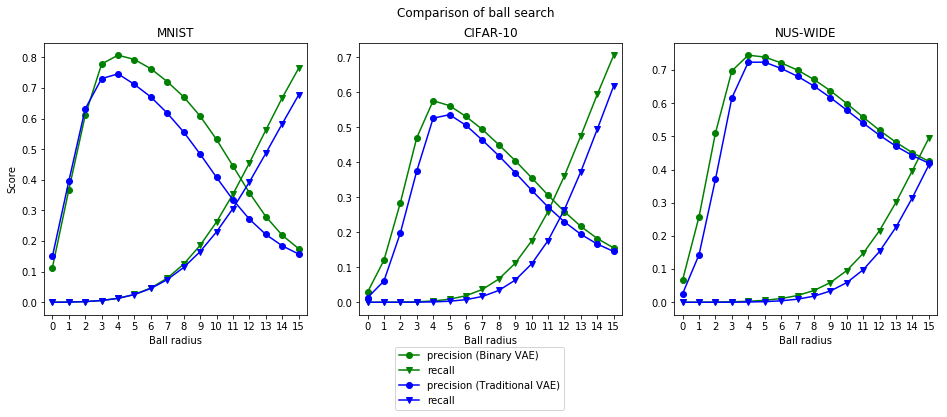

In [9]:
choosed_data = [ "MNIST", "CIFAR-10", "NUS-WIDE"]
f, axx = plt.subplots(1, len(choosed_data), figsize=(16,5), sharey=False)

b_aux = 16
for z in range(len(choosed_data)):
    dat = choosed_data[z].lower()

    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["p"][:b_aux],'go-',label="precision (Binary VAE)")
    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["r"][:b_aux],'gv-', label='recall' ) 
    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["p"][:b_aux],'bo-',label="precision (Traditional VAE)")
    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["r"][:b_aux],'bv-', label='recall' ) 
    axx[z].set_title(choosed_data[z])
    axx[z].set_xticks(ball_radius)
    axx[z].set_xlabel("Ball radius")
    axx[z].set_xlim(-0.5, len(ball_radius[:b_aux])-.5)
    #axx[z].set_ylim(-0.05)
    
    if z == 0:
        axx[z].set_ylabel("Score")
        axx[z].legend(bbox_to_anchor=(2, -0.1))
        
f.suptitle("Comparison of ball search")
plt.show()